# Clasificador de Vinos con KNN (Wine Quality - Red)

**Objetivo:** predecir la calidad del vino (label) usando sus características químicas con **K-Nearest Neighbors**.

> Nota para el futuro: KNN depende de **distancias**, así que **escalar** las features es casi obligatorio para que ninguna columna domine el cálculo de distancia.



In [51]:
# ==========================================
# Paso 0: Imports
# ==========================================

import pandas as pd  # Yo uso pandas para cargar y explorar datos.
import numpy as np   # Yo uso numpy para utilidades numéricas.
import matplotlib.pyplot as plt  # Yo uso matplotlib para graficar.


In [52]:
# ==========================================
# Paso 1: Cargar datos y exploración rápida
# ==========================================

url = "https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv"  # Yo guardo el link del CSV.
df = pd.read_csv(url, sep = ";")  # Yo cargo el dataset.

print("Shape (filas, columnas):", df.shape)  # Yo reviso tamaño.
df.head()  # Yo miro primeras filas.


Shape (filas, columnas): (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [53]:
# Se reviso la estructura (tipos, nulos, etc.).
df.info()

# Se obtengo estadísticos rápidos de las variables numéricas.
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [54]:
# Se reviso si hay duplicados.
print("Duplicados:", df.duplicated().sum())

# (Opcional) Si quiero eliminarlos, lo haría así:
# df = df.drop_duplicates()


Duplicados: 240


In [55]:
# Se reviso valores nulos.
print("Nulos por columna:\n", df.isnull().sum())


Nulos por columna:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [56]:
# Se reviso el balance de clases (Quality es mi target con 0/1/2).
print("Distribución de clases (quality):\n", df["quality"].value_counts())
print("\nProporción de clases (quality):\n", df["quality"].value_counts(normalize=True))


Distribución de clases (quality):
 quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

Proporción de clases (quality):
 quality
5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: proportion, dtype: float64


## Paso 2 — Preparación: X, y y train/test split (80/20)

> Nota para el futuro: uso **stratify=y** porque esto es clasificación multicategoría (0,1,2) y quiero mantener la proporción de clases en train/test.



In [57]:
from sklearn.model_selection import train_test_split  # Yo importo la función para dividir los datos.

# Se separo features y target.
X = df.drop(columns=["quality"])  # Yo tomo todas las columnas menos la etiqueta.
y = df["quality"]                 # Yo tomo la columna objetivo.

# Se divido en train/test (80/20) y estratifico.
X_train, X_test, y_train, y_test = train_test_split(
    X,               # features
    y,               # target
    test_size=0.2,   # 20% para test
    random_state=42, # reproducibilidad
    stratify=y       # mantener proporción de clases
)

print("Train:", X_train.shape, "| Test:", X_test.shape)


Train: (1279, 11) | Test: (320, 11)


## Paso 3 — Escalado de datos (recomendado en KNN)

> Nota para el futuro: **SIEMPRE** hago `fit` del scaler solo con **train** y luego `transform` a train y test, para evitar data leakage.



In [58]:
from sklearn.preprocessing import StandardScaler  # Yo importo el escalador estándar.

scaler = StandardScaler()  # Yo inicializo el escalador.

# Se ajusto (fit) el scaler SOLO con X_train.
X_train_scaled = scaler.fit_transform(X_train)

# Se transformo X_test con el mismo scaler (sin re-ajustar).
X_test_scaled = scaler.transform(X_test)

print("Escalado listo. Shapes:", X_train_scaled.shape, X_test_scaled.shape)


Escalado listo. Shapes: (1279, 11) (320, 11)


## Paso 4 — Entrenar KNN con un k inicial y evaluar

Voy a empezar con un `k` inicial (por ejemplo 5) y luego lo optimizo probando varios k.



In [59]:
from sklearn.neighbors import KNeighborsClassifier  # Yo importo el modelo KNN de clasificación.

# Se elijo un k inicial.
k_inicial = 5

# Se creo el modelo.
knn = KNeighborsClassifier(n_neighbors=k, weights="distance")



# Se entreno el modelo (en KNN esto básicamente guarda datos para comparar distancias).
knn.fit(X_train_scaled, y_train)

# Se predigo para test.
y_pred = knn.predict(X_test_scaled)

y_pred[:10]  # Yo miro algunas predicciones.


array([7, 5, 5, 6, 5, 6, 5, 5, 5, 8])

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Yo importo métricas.

# Se calculo accuracy.
acc = accuracy_score(y_test, y_pred)
print("Accuracy (k =", k_inicial, "):", round(acc, 4))

# Se muestro matriz de confusión.
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n", cm)

# Se muestro reporte de clasificación (precision/recall/f1 por clase).
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy (k = 5 ): 0.675

Confusion matrix:
 [[  0   0   1   1   0   0]
 [  0   0   7   4   0   0]
 [  0   0 101  34   1   0]
 [  0   0  31  89   8   0]
 [  0   0   0  14  25   1]
 [  0   0   0   1   1   1]]

Classification report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.74      0.73       136
           6       0.62      0.70      0.66       128
           7       0.71      0.62      0.67        40
           8       0.50      0.33      0.40         3

    accuracy                           0.68       320
   macro avg       0.43      0.40      0.41       320
weighted avg       0.65      0.68      0.66       320



/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Paso 5 — Optimización de k (1 a 20)

Voy a probar k desde 1 hasta 20, guardar los accuracy y graficar `accuracy vs k` para elegir el mejor.



In [61]:
k_values = list(range(1, 21))  # Yo defino la lista de K a probar.
accuracies = []                # Yo creo una lista para guardar accuracies.

for k in k_values:  # Yo itero sobre cada k.
    model = KNeighborsClassifier(n_neighbors=k)  # Yo creo el modelo con ese k.
    model.fit(X_train_scaled, y_train)           # Yo entreno con train escalado.
    pred = model.predict(X_test_scaled)          # Yo predigo en test escalado.
    accuracies.append(accuracy_score(y_test, pred))  # Yo guardo accuracy.

# Se reviso los resultados rápidamente.
results = pd.DataFrame({"k": k_values, "accuracy": accuracies})
results


,k,accuracy
0,1,0.625000
1,2,0.587500
2,3,0.575000
3,4,0.581250
4,5,0.609375
5,6,0.593750
6,7,0.593750
7,8,0.590625
8,9,0.600000
9,10,0.596875


In [62]:
# Se encuentro el mejor k por accuracy.
best_idx = int(np.argmax(accuracies))  # índice del mayor accuracy
best_k = k_values[best_idx]            # k asociado
best_acc = accuracies[best_idx]        # accuracy máximo

print("Mejor k:", best_k)
print("Mejor accuracy:", round(best_acc, 4))


Mejor k: 1
Mejor accuracy: 0.625


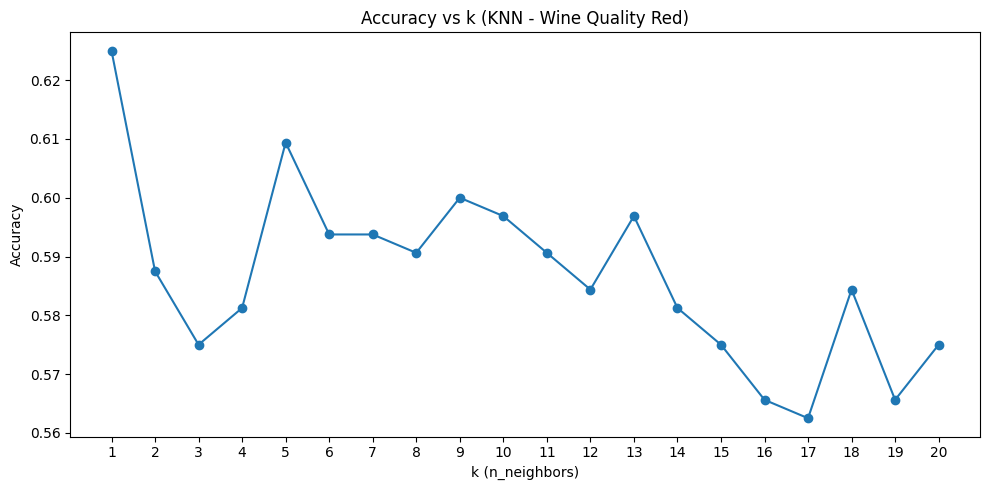

In [63]:
# Se grafico accuracy vs k para ver el comportamiento.
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker="o")
plt.title("Accuracy vs k (KNN - Wine Quality Red)")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.tight_layout()
plt.show()


## Paso 6 — Entrenar modelo final con el mejor k y guardar (modelo + scaler)

> Nota para el futuro: debo guardar **también el scaler**, porque si no, al usar el modelo en producción no podré escalar datos nuevos igual.



Accuracy FINAL (k = 1 ): 0.625

Classification report FINAL:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.14      0.18      0.16        11
           5       0.74      0.66      0.70       136
           6       0.64      0.66      0.65       128
           7       0.49      0.57      0.53        40
           8       0.17      0.33      0.22         3

    accuracy                           0.62       320
   macro avg       0.36      0.40      0.38       320
weighted avg       0.64      0.62      0.63       320



/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


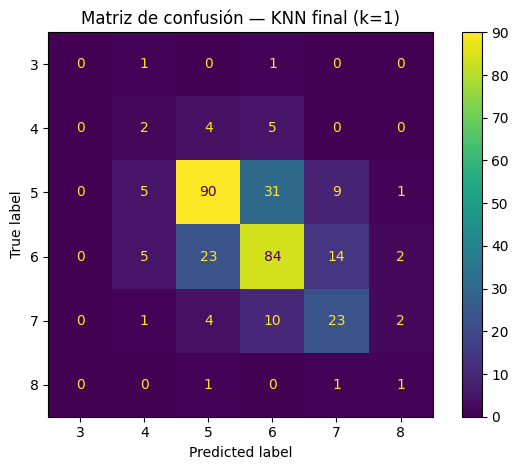

Guardado:
- wine_knn_scaler.joblib
- wine_knn_model_k1.joblib


In [64]:
from sklearn.metrics import ConfusionMatrixDisplay  # Yo importo display para matriz.
import joblib  # Yo uso joblib para guardar el modelo y el scaler.

# Se entreno el modelo final con best_k.
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train_scaled, y_train)

# Se evalúo una vez más el modelo final.
final_pred = final_model.predict(X_test_scaled)
final_acc = accuracy_score(y_test, final_pred)

print("Accuracy FINAL (k =", best_k, "):", round(final_acc, 4))
print("\nClassification report FINAL:\n", classification_report(y_test, final_pred))

# Se grafico matriz de confusión final.
ConfusionMatrixDisplay.from_predictions(y_test, final_pred)
plt.title(f"Matriz de confusión — KNN final (k={best_k})")
plt.tight_layout()
plt.show()

# Se guardo scaler y modelo.
joblib.dump(scaler, "wine_knn_scaler.joblib")
joblib.dump(final_model, f"wine_knn_model_k{best_k}.joblib")

print("Guardado:")
print("- wine_knn_scaler.joblib")
print(f"- wine_knn_model_k{best_k}.joblib")
